# Assignment 1

In [58]:
from scipy import io
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import copy
import tikzplotlib
import seaborn
from scipy.io.wavfile import write
%matplotlib notebook
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
np.random.seed(1)

In [2]:
# load dataset
filepath = os.path.abspath('./../../../data/ass_01/amp_data.mat')
assert os.path.exists(filepath), 'Please download the dataset. I cannot find it at: %s' %(filepath)
file = io.loadmat(filepath)
amp_data = file['amp_data']

# Question 1

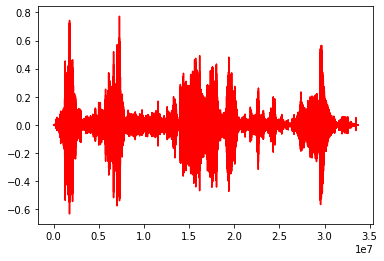

In [3]:
# plot data along t axis
save_filename_png = os.path.abspath("./presentation/presentation_figures/fig_01.png")
# save_filename_tex = os.path.abspath("./presentation/presentation_figures/fig_01.tex")

plt.figure()
plt.plot(amp_data[:, 0], 'r')
plt.savefig(save_filename_png)
plt.show()
# tikzplotlib.save(save_filename_tex)

<IPython.core.display.Javascript object>


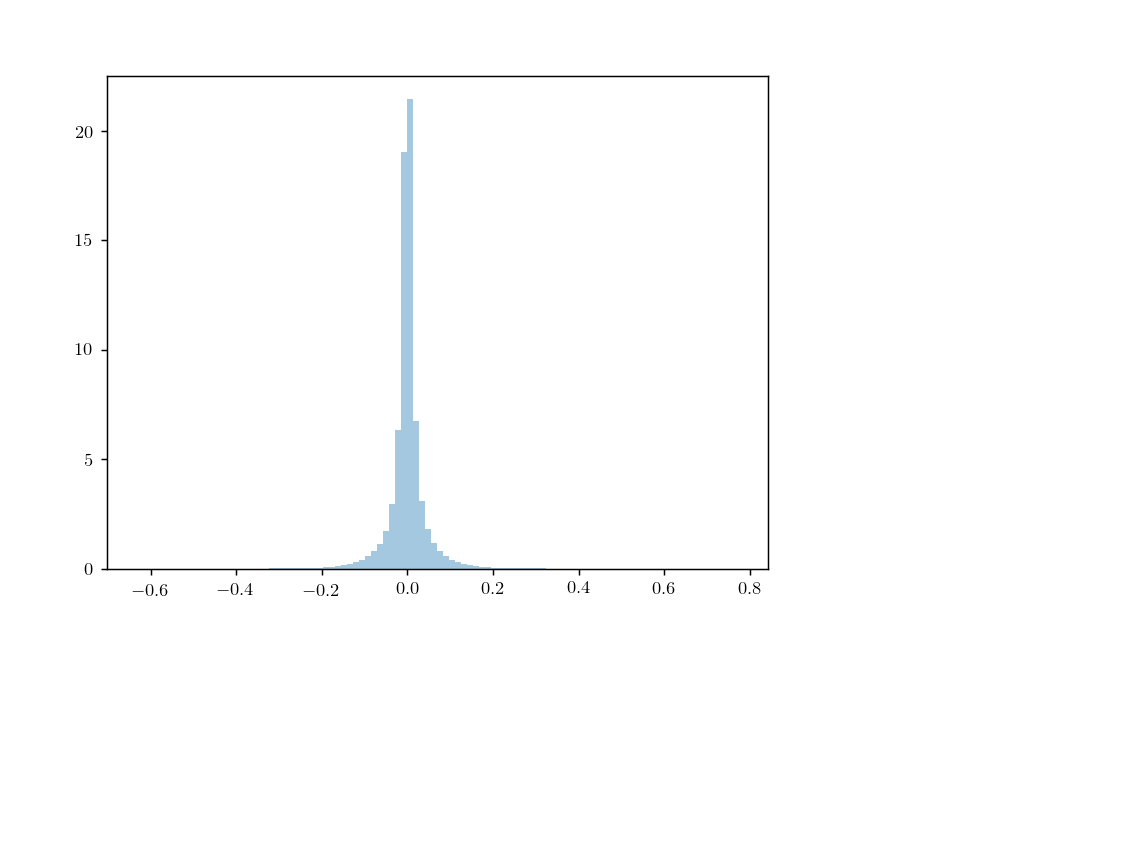

In [59]:
# plot histogram
save_filename_png = os.path.abspath("./presentation/presentation_figures/fig_02.png")
plt.figure()
seaborn.distplot(amp_data[:, 0], bins=100, kde=False, norm_hist=True)
plt.savefig(save_filename_png)
plt.show()

In [22]:
class Dataset:
    amp_data = amp_data
    
    def __init__(self, D: int, split_pcg = [0.7, 0.15, 0.15]):
        """
        
        :param D: dimensionality 
        """
        
        # rearrange signal into non-overlapping arrays of shape [N x D+1]
        self.remaining_samples = amp_data.shape[0] % (D+1)
        self.XY = amp_data[:-self.remaining_samples] if self.remaining_samples > 0 else amp_data
        self.XY = self.XY.reshape((int(self.XY.shape[0]/(D+1)), (D+1)))
        
        # shuffle (not inplace)
        self.shuffle_indices = np.random.permutation(self.XY.shape[0])
        self.XY_shuffled = np.take(self.XY, self.shuffle_indices, axis=0)
        
        # split into training
        self.nof_tr = np.int(np.floor(self.XY.shape[0] * split_pcg[0]))
        self.nof_val = np.int(np.floor(self.XY.shape[0] * split_pcg[1]))
        self.nof_test = np.int(np.floor(self.XY.shape[0] * split_pcg[2]))
        
        train_start = 0
        val_start = self.nof_tr
        test_start = self.nof_tr + self.nof_val
        
        self.X_shuf_train = self.XY_shuffled[0 : self.nof_tr, :D]
        self.y_shuf_train = self.XY_shuffled[0 : self.nof_tr, D]
        
        self.X_shuf_val = self.XY_shuffled[val_start : val_start + self.nof_val, :D]
        self.y_shuf_val = self.XY_shuffled[val_start : val_start + self.nof_val, D]
        
        self.X_shuf_test = self.XY_shuffled[test_start : test_start + self.nof_test, :D]
        self.y_shuf_test = self.XY_shuffled[test_start : test_start + self.nof_test, D]
    
D = 20
split_pcg = [0.7, 0.15, 0.15]
data = Dataset(D, split_pcg)

# Question 2

<IPython.core.display.Javascript object>


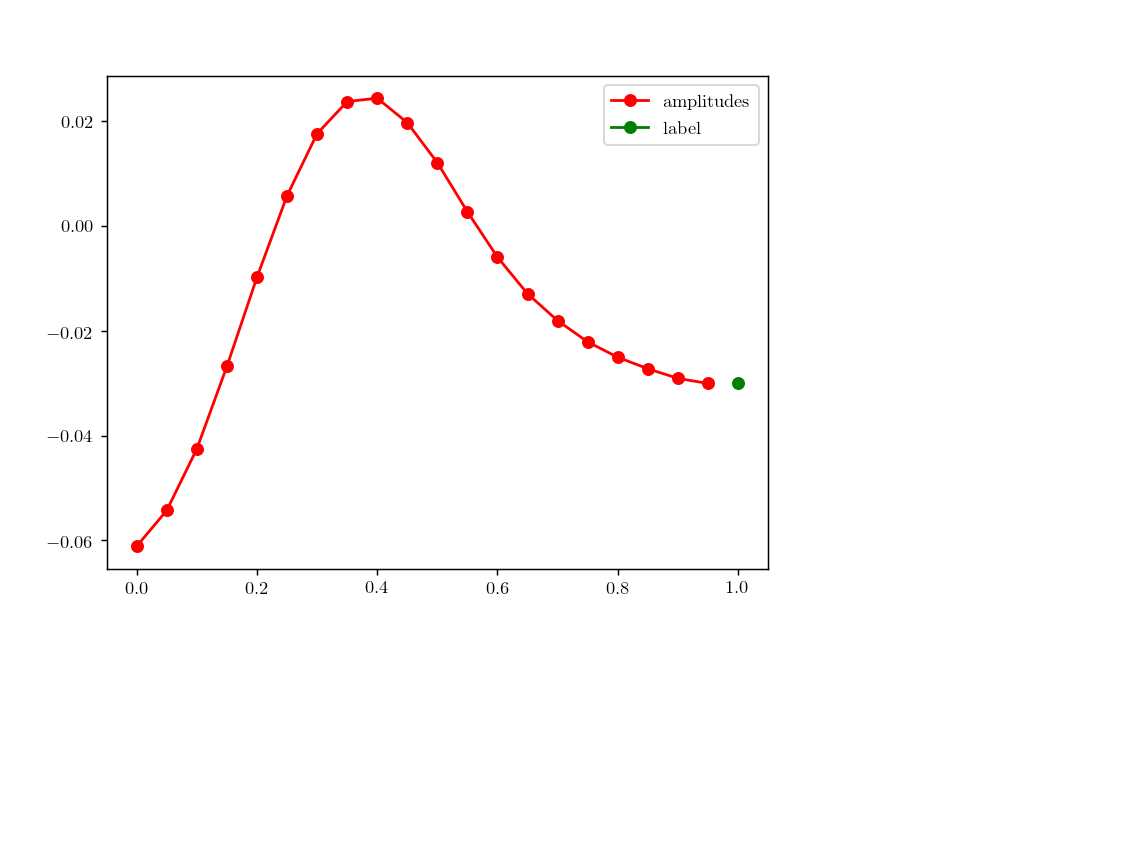

In [60]:
# plot single row 
save_filename_png = os.path.abspath("./presentation/presentation_figures/fig_03.png")
i = 1000 # nof row

plt.figure()
plt.plot(np.linspace(0, 19/20, 20), data.X_shuf_train[i], 'r-o', label="amplitudes");
plt.plot(1, data.y_shuf_train[i], 'g-o', label = "label");
plt.legend();
plt.savefig(save_filename_png)
plt.show(block=False);

In [107]:
class Model:
    def __init__(self, phi):
        self.phi = phi
        self.w = None
        
    def fit(self, x: np.array, y: np.array):
        '''
        x: NxD
        y: Nx1
        
        w : Kx1
        '''
        assert len(y.shape) == 2
        assert len(x.shape) == 2
        assert x.shape[0] == y.shape[0]
        
        phi_x = self.phi(x)
        assert len(phi_x.shape) == 2
        assert phi_x.shape[0] == x.shape[0]
        
        w, residuals, rank, sv = np.linalg.lstsq(phi_x, y, rcond=None)
        self.w = w
        self.residuals = residuals
        
        assert len(self.w.shape) == 2
        assert self.w.shape[0] == phi_x.shape[1]
        assert self.w.shape[1] == 1
        return w
    
    def predict(self, x: np.array):
        '''
        x : NxD
        
        Nx1
        '''
        assert len(x.shape) == 2
        phi_x = self.phi(x)
        assert len(phi_x.shape) == 2
        assert phi_x.shape[0] == x.shape[0]
        assert phi_x.shape[1] == w.shape[0]
        
        return np.matmul(phi_x, self.w)
    
    
    def mse(self, X, Y):
        '''
        X : NxD
        Y : Nx1
        
        scalar
        '''
        assert len(X.shape) == 2
        assert len(Y.shape) == 2
        assert Y.shape[1] == 1
        assert X.shape[0] == Y.shape[0]
        
        Y_pred = self.predict(X)
        Y_pred.shape
        assert Y_pred.shape == Y.shape
        return np.mean(np.square(Y - Y_pred))
    
    def mae(self, X, Y):
        '''
        X : NxD
        Y : Nx1
        
        scalar
        '''
        assert len(X.shape) == 2
        assert len(Y.shape) == 2
        assert Y.shape[1] == 1
        assert X.shape[0] == Y.shape[0]
        
        Y_pred = self.predict(X)
        print(Y_pred.shape)
        assert Y_pred.shape == Y.shape
        return np.mean(np.abs(Y - Y_pred))

def affine_phi(x):
    assert len(x.shape) == 2
    phi_x = np.concatenate((np.ones_like(x), x), axis=1)
    return phi_x

def quartic_phi(x):
    assert len(x.shape) == 2
    phi_x = np.concatenate((np.ones_like(x), x, x**2, x**3, x**4), axis=1)
    return phi_x


linear_model = Model(phi=affine_phi)
quartic_model = Model(phi=quartic_phi)


x = np.expand_dims(np.linspace(0, 19 / 20, 20), -1)
y = np.expand_dims(data.X_shuf_train[i], -1)


linear_model.fit(x, y)
quartic_model.fit(x, y)

x_ext = np.expand_dims(np.linspace(-0.1, 1.1, 200), -1)

# subquestion a
plt.figure()

# training points
plt.plot(x, y, 'b-o', label = 'training examples')
# test point
plt.plot(np.array([[1]]), data.y_shuf_train[i], 'r-o', label = 'test examples')

# fit line
plt.plot(x_ext, linear_model.predict(x_ext), 'g-', label = 'fit line')
# fit quartic
plt.plot(x_ext, quartic_model.predict(x_ext), 'y-', label = 'fit quartic')

# prediction of linear model
plt.plot(np.array([[1]]), linear_model.predict(np.array([[1]])), 'go', label = '$\hat{y}_{lin}$')
# prediction of quartic model
plt.plot(np.array([[1]]), quartic_model.predict(np.array([[1]])), 'yo', label = '$\hat{y}_{quartic}$')

plt.xlabel("time")
plt.ylabel("amplitudes")
plt.legend();
plt.savefig(save_filename_png)
plt.show(block=False)

<IPython.core.display.Javascript object>

AssertionError: 

In [90]:
mae = linear_model.mae(np.ones((data.y_shuf_train.shape[0], 1)), np.expand_dims(data.y_shuf_train, -1))
mse = linear_model.mse(np.ones((data.y_shuf_train.shape[0], 1)), np.expand_dims(data.y_shuf_train, -1))

print(mae, mse, data.y_shuf_train.mean(), data.y_shuf_train.std())

mae = quartic_model.mae(np.ones((data.y_shuf_train.shape[0], 1)), np.expand_dims(data.y_shuf_train, -1))
mse = quartic_model.mse(np.ones((data.y_shuf_train.shape[0], 1)), np.expand_dims(data.y_shuf_train, -1))

print(mae, mse, data.y_shuf_train.mean(), data.y_shuf_train.std())
print(linear_model.w.shape)

(1123775, 1)
0.025872784889966114 0.0018082886965321101 -1.4214778444514583e-05 0.04153787414441795
(1123775, 1)
0.025055589343008434 0.0017766455173338688 -1.4214778444514583e-05 0.04153787414441795
(2, 1)


# Question 3

In [94]:
C = 20
K = 3
def Phi(C, K):
    t = np.linspace(0, (C-1)/C, C)
    return np.stack([t**k for k in range(K)], axis=1)

In [95]:
x_tmp = np.expand_dims(data.X_shuf_train[i], -1)

def phi_t(t):
    return np.stack([t**k for k in range(K)], axis=1).T

def make_vv(C, K, x_tmp):
    x_tmp = np.expand_dims(x_tmp, -1)
    F = Phi(C,K)
    F_T = np.transpose(F)
    
    return ((((F_T.dot(F))**-1).dot(F_T.dot(x_tmp)).T).dot(phi_t(np.array([1]))).dot(x_tmp.T).T / ((x_tmp.T).dot(x_tmp))).T

In [97]:
# demonstration
C = 20
K = 5
v = make_vv(C, K, data.X_shuf_train[i])

print(quartic_model.predict(np.array([[1]])))

print(v.dot(np.expand_dims(data.X_shuf_train[i], -1)))


[[-0.00717316]]
[[-0.81008998]]


# Question 4

In [98]:
def new_affine_phi(X):
    assert len(X.shape) == 2, "Shape of all thing must have length 2"
    raw_ones_column = np.expand_dims(np.ones(X.shape[0]), -1)
    return np.concatenate((X, raw_ones_column), axis=1)

affine_model = Model(new_affine_phi)
w = affine_model.fit(data.X_shuf_train, np.expand_dims(data.y_shuf_train, -1))

# print(affine_model.mse(X_shuf_train, np.expand_dims(y_shuf_train, -1)))
# print(affine_model.mse(X_shuf_val, np.expand_dims(y_shuf_val, -1)))

In [99]:
C = np.arange(19,-1, -1)

In [100]:
print(C)

[19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]


In [101]:
data.X_shuf_train[:,C[-1]:].shape

(1123775, 20)

In [102]:
affine_model1 = Model(new_affine_phi)
affine_model1.fit(data.X_shuf_train[:,C[0]:], np.expand_dims(data.y_shuf_train, -1))
affine_model1.mse(data.X_shuf_train[:,C[0]:], np.expand_dims(data.y_shuf_train, -1))

3.6694438797605264e-05

In [103]:
mse_tr = []
mse_val = []
mse_te = []
affine_model = []
for i, c in enumerate(C):
    affine_model.append(Model(new_affine_phi))
    affine_model[i].fit(data.X_shuf_train[:,c:], np.expand_dims(data.y_shuf_train, -1))
    train_err = affine_model[i].mse(data.X_shuf_train[:,c:], np.expand_dims(data.y_shuf_train, -1))
    valid_err = affine_model[i].mse(data.X_shuf_val[:,c:], np.expand_dims(data.y_shuf_val, -1))
    test_err = affine_model[i].mse(data.X_shuf_test[:,c:], np.expand_dims(data.y_shuf_test, -1))
    print("\nModel with %d weigths + bias:" %(20-c))
    print("training err: ", train_err)
    print("valid err   : ", valid_err)
    print("test err    : ", test_err)
    print("\n")
    mse_tr.append(train_err)
    mse_val.append(valid_err)
    mse_te.append(test_err)


Model with 1 weigths + bias:
training err:  3.6694438797605264e-05
valid err   :  3.689856109437479e-05
test err    :  3.675872037520024e-05



Model with 2 weigths + bias:
training err:  1.1635605286067409e-05
valid err   :  1.175259173222697e-05
test err    :  1.1448100715770535e-05



Model with 3 weigths + bias:
training err:  9.94185264896309e-06
valid err   :  9.904535711573072e-06
test err    :  9.585149698510304e-06



Model with 4 weigths + bias:
training err:  9.554635329107048e-06
valid err   :  9.60204726303713e-06
test err    :  9.27149009160555e-06



Model with 5 weigths + bias:
training err:  9.086551718716575e-06
valid err   :  9.169639933137681e-06
test err    :  8.904290181637821e-06



Model with 6 weigths + bias:
training err:  8.863973052730228e-06
valid err   :  8.966713946206545e-06
test err    :  8.831033104775198e-06



Model with 7 weigths + bias:
training err:  8.289126580983711e-06
valid err   :  8.445778694877342e-06
test err    :  8.550776804825847e-06



<IPython.core.display.Javascript object>


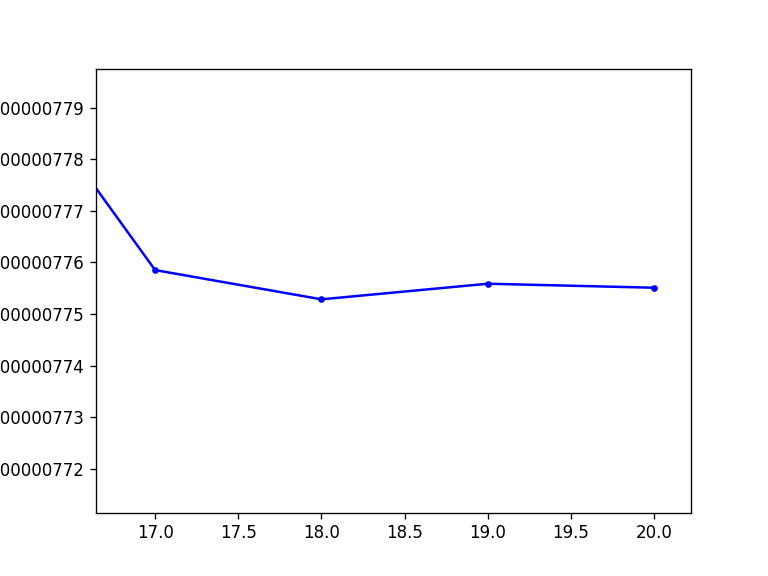

In [54]:
plt.figure()
plt.plot(20-C, mse_tr, 'r.-')
plt.plot(20-C, mse_val, 'b.-')
plt.plot(20-C, mse_te, 'g.-')
plt.show()

best model is 11


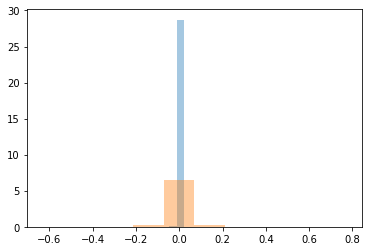

In [38]:
c_arg = np.argmin(np.array(mse_val))
print("best model is %d" %c_arg)

plt.figure()
res = affine_model[c_arg].predict(data.X_shuf_val[:,C[c_arg]:]) - np.expand_dims(data.y_shuf_val, -1)
seaborn.distplot(res, bins = 10, kde=False, norm_hist=True)
seaborn.distplot(amp_data[:, 0], bins=10, kde=False, norm_hist=True)
plt.show()